# ARIMA Model for  AAPL stock
Only for closing prices

In [1]:
!pip install --user statsmodels

In [2]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

%config InlineBackend.figure_format = 'retina'

In [3]:
df = pd.read_csv('gs://cloud-training/ai4f/AAPL10Y.csv')

df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

print(df.shape)

df.head()

(2517, 5)


,close,volume,open,high,low
date,,,,,
2009-06-03,20.1357,140628992.0,20.0000,20.1586,19.8671
2009-06-04,20.5343,136628071.0,20.0186,20.5971,20.0057
2009-06-05,20.6671,157944127.0,20.7586,20.9143,20.4586
2009-06-08,20.5500,232466290.0,20.5457,20.6043,19.9186
2009-06-09,20.3886,168830811.0,20.5443,20.6514,20.0786


resample the data such that stock closing prices are aggregated on a weekly basis. 

In [5]:
# resample data
df_week = df.resample('w').mean()
df_week = df_week[['close']]
df_week.head()

,close
date,
2009-06-07,20.445700
2009-06-14,20.106860
2009-06-21,19.525140
2009-06-28,19.711440
2009-07-05,20.258925


Let's create a column for weekly returns. Take the log to of the returns to normalize large fluctuations.

In [8]:
# column for weekly returns
df_week['weekly_ret'] = np.log(df_week['close']).diff()
df_week.head()

,close,weekly_ret,weekly_ret2,weekly_ret3
date,,,,
2009-06-07,20.445700,NaN,3.017773,NaN
2009-06-14,20.106860,-0.016712,3.001061,-0.338840
2009-06-21,19.525140,-0.029358,2.971703,-0.581720
2009-06-28,19.711440,0.009496,2.981199,0.186300
2009-07-05,20.258925,0.027396,3.008595,0.547485


`np.log(df_week['close']).diff()` - liczy difference już między log z previous cell and current cell   
(patrz col weekly_ret2, tam są pełne log(values) z których te diff są liczone)

In [9]:
df_week.shape

(523, 4)

In [11]:
# drop null rows
df_week.dropna(inplace=True)
df_week.shape

(522, 4)

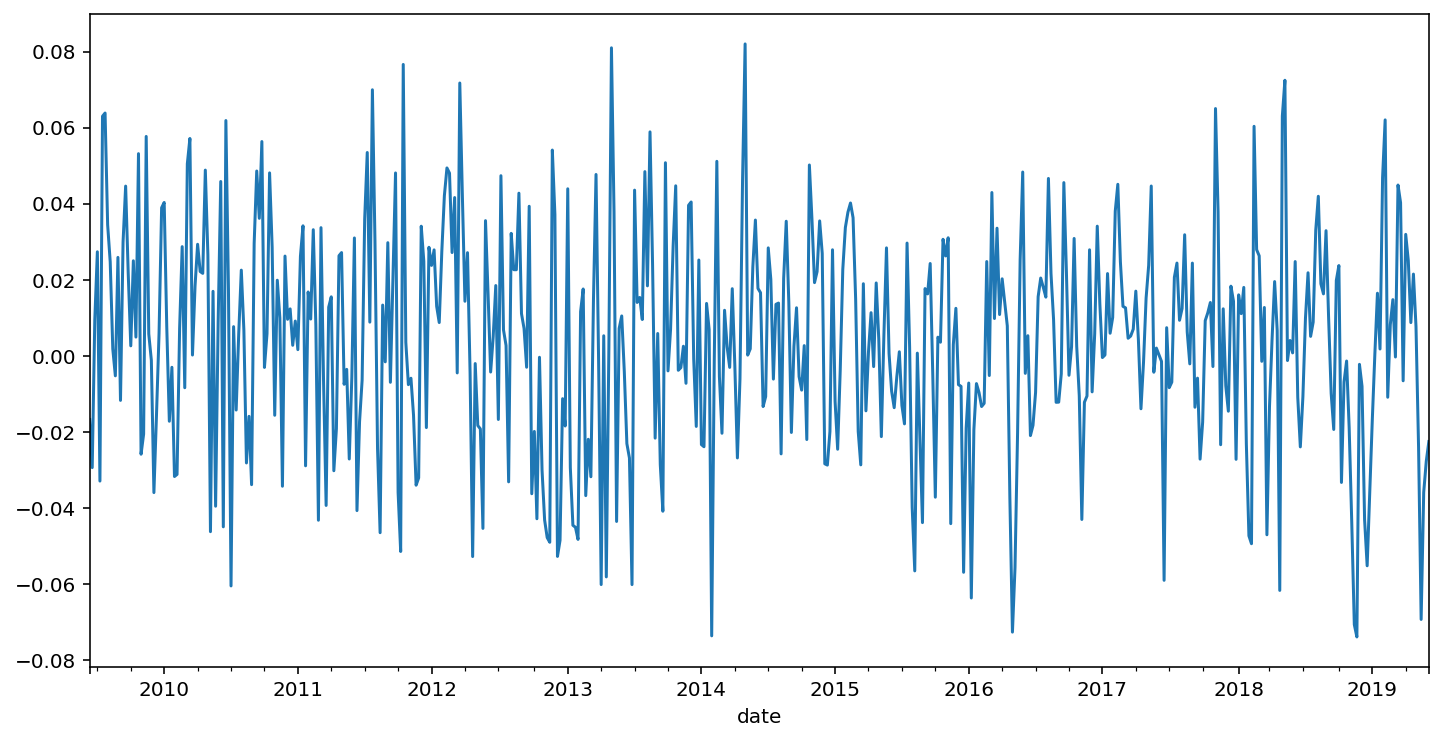

In [12]:
df_week.weekly_ret.plot(kind='line', figsize=(12, 6));

In [16]:
udiff = df_week[['weekly_ret']]
udiff.head()

,weekly_ret
date,
2009-06-14,-0.016712
2009-06-21,-0.029358
2009-06-28,0.009496
2009-07-05,0.027396
2009-07-12,-0.032905


In [20]:
# test for stationarity 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

rolmean.tail()

,weekly_ret
date,
2019-05-12,0.011857
2019-05-19,0.010176
2019-05-26,0.009222
2019-06-02,0.007809
2019-06-09,0.005859


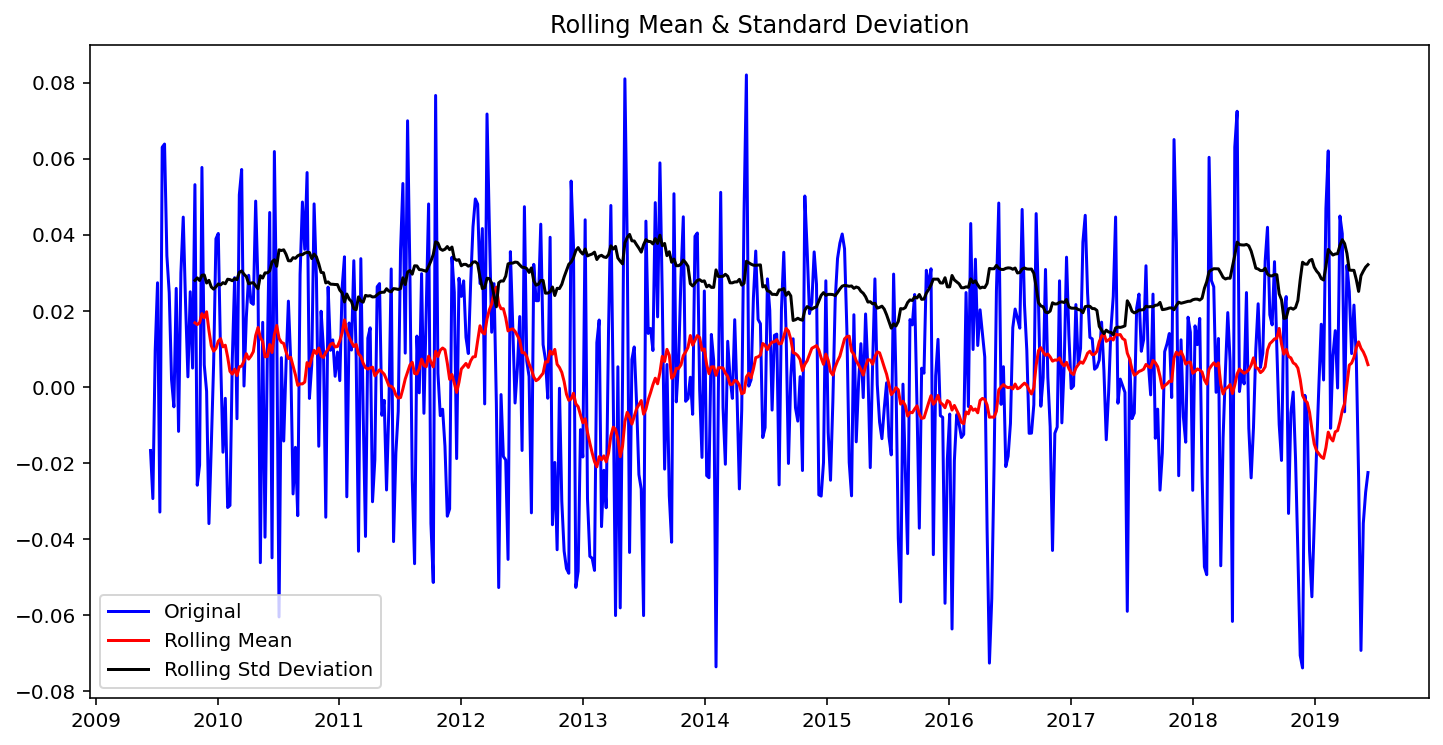

In [21]:
plt.figure(figsize=(12, 6))
orig = plt.plot(udiff, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

In [22]:
# Dickey-Fuller test
dftest = sm.tsa.adfuller(udiff.weekly_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput

Test Statistic                -1.105002e+01
p-value                        5.107869e-20
#Lags Used                     2.000000e+00
Number of Observations Used    5.190000e+02
Critical Value (1%)           -3.443013e+00
Critical Value (5%)           -2.867125e+00
Critical Value (10%)          -2.569745e+00
dtype: float64

## ACF and PACF Charts

In [24]:
udiff.head()

,weekly_ret
date,
2009-06-14,-0.016712
2009-06-21,-0.029358
2009-06-28,0.009496
2009-07-05,0.027396
2009-07-12,-0.032905


In [27]:
udiff.values[:5]

array([[-0.01671154],
       [-0.02935818],
       [ 0.00949631],
       [ 0.02739626],
       [-0.03290466]])

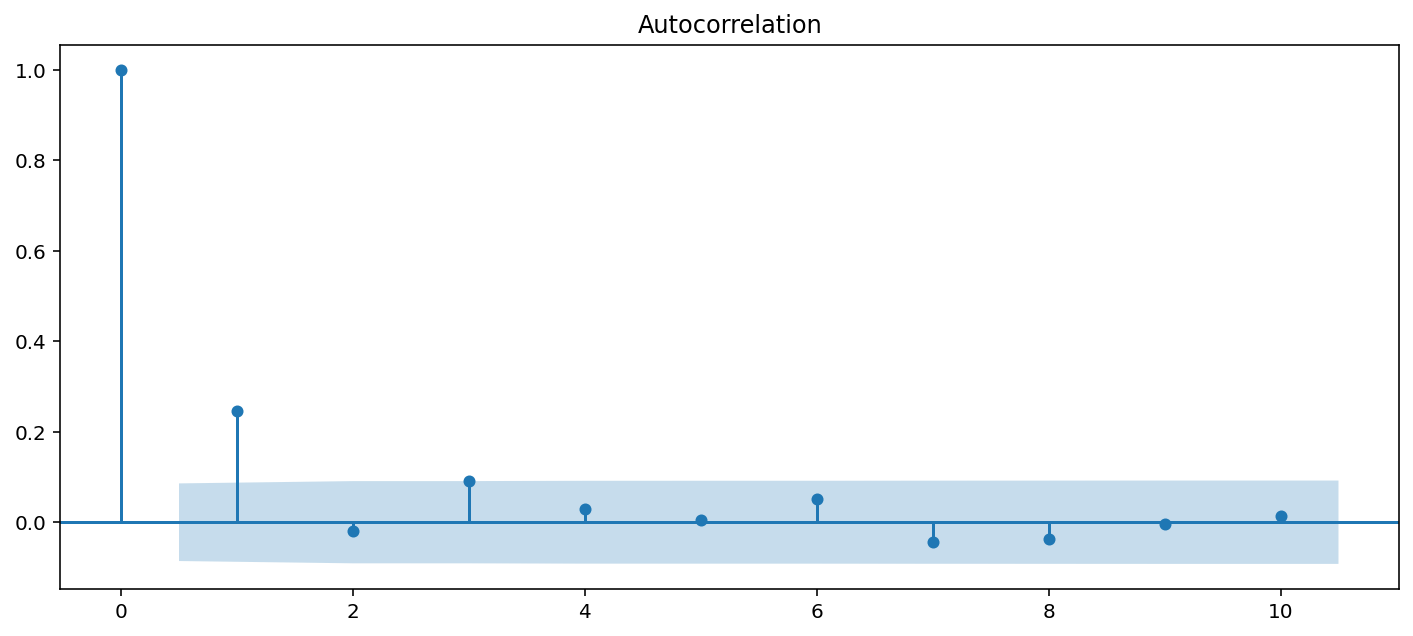

In [23]:
from statsmodels.graphics.tsaplots import plot_acf

# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(udiff.values, lags=10, ax=ax)
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(udiff.values, lags=10, ax=ax)
plt.show()

##  ARIMA Model


In [28]:
from statsmodels.tsa.arima_model import ARMA

# Notice that you have to use udiff - the differenced data rather than the original data. 
ar1 = ARMA(tuple(udiff.values), (3, 1)).fit()
ar1.summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  522
Model:                     ARMA(3, 1)   Log Likelihood                1131.581
Method:                       css-mle   S.D. of innovations              0.028
Date:                Sun, 10 Jan 2021   AIC                          -2251.163
Time:                        00:24:54   BIC                          -2225.617
Sample:                             0   HQIC                         -2241.157
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.002      2.442      0.015       0.001       0.007
ar.L1.y        0.0601      0.264      0.227      0.820      -0.458       0.578
ar.L2.y       -0.0591      0.084     -0.705      0.481      -0.223       0.105
ar.L3.y        0.1080      0.053      2.049      0.040       0.005       0.211
ma.L1.y        0.2219      0.265      0.839      0.401      -0.297       0.740
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8278           -1.8757j            2.0502           -0.3161
AR.2           -0.8278           +1.8757j            2.0502            0.3161
AR.3            2.2031           -0.0000j            2.2031           -0.0000
MA.1           -4.5055           +0.0000j            4.5055            0.5000
-----------------------------------------------------------------------------
"""

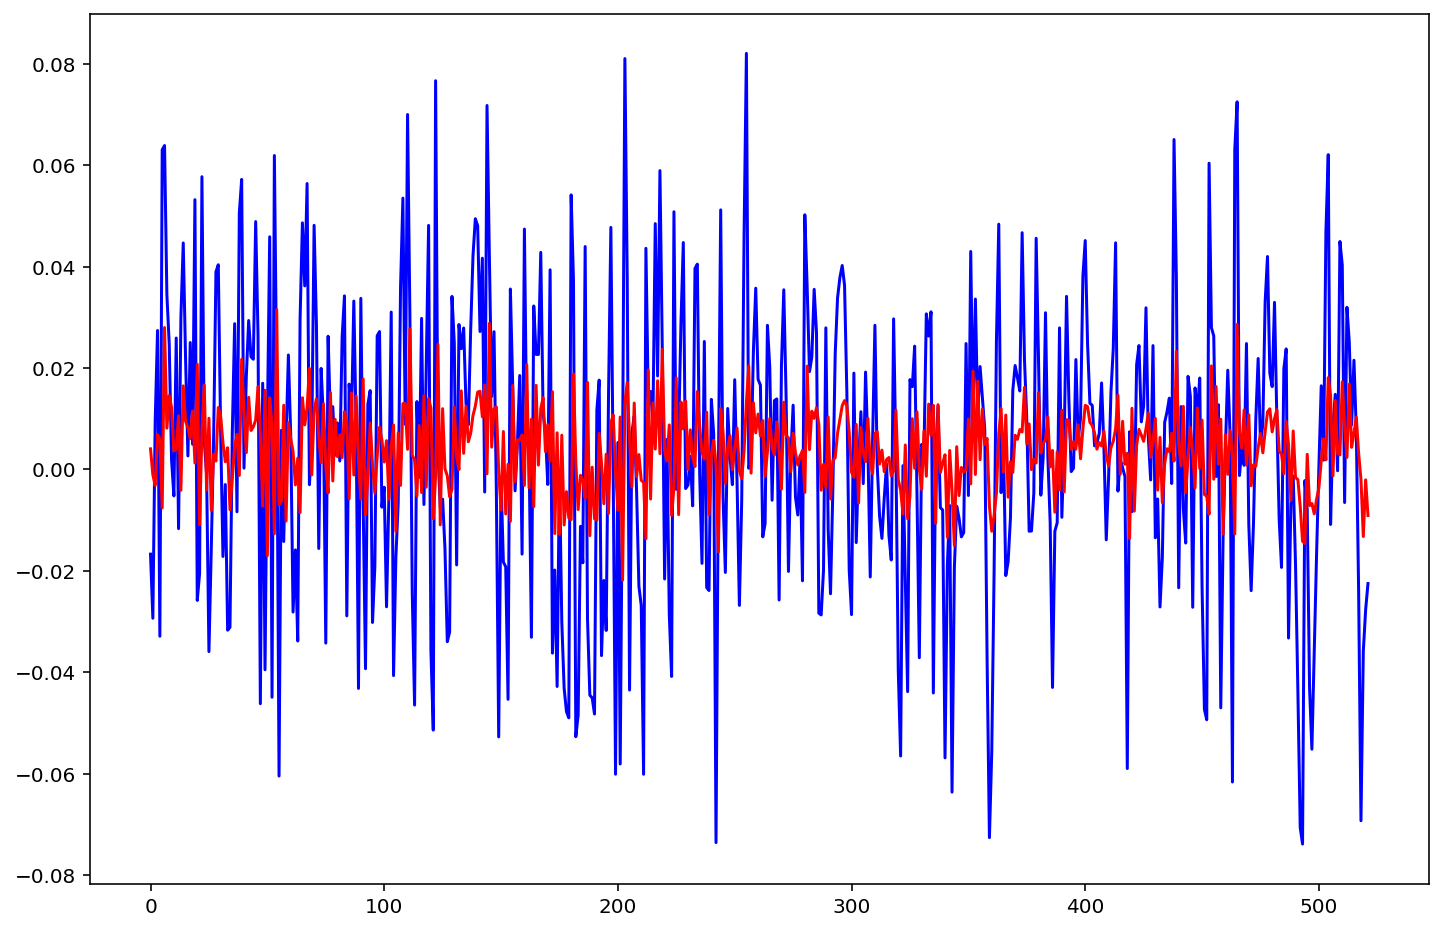

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')
preds = ar1.fittedvalues
plt.plot(preds, color='red')
plt.show()

Let's make a forecast 2 weeks ahead:

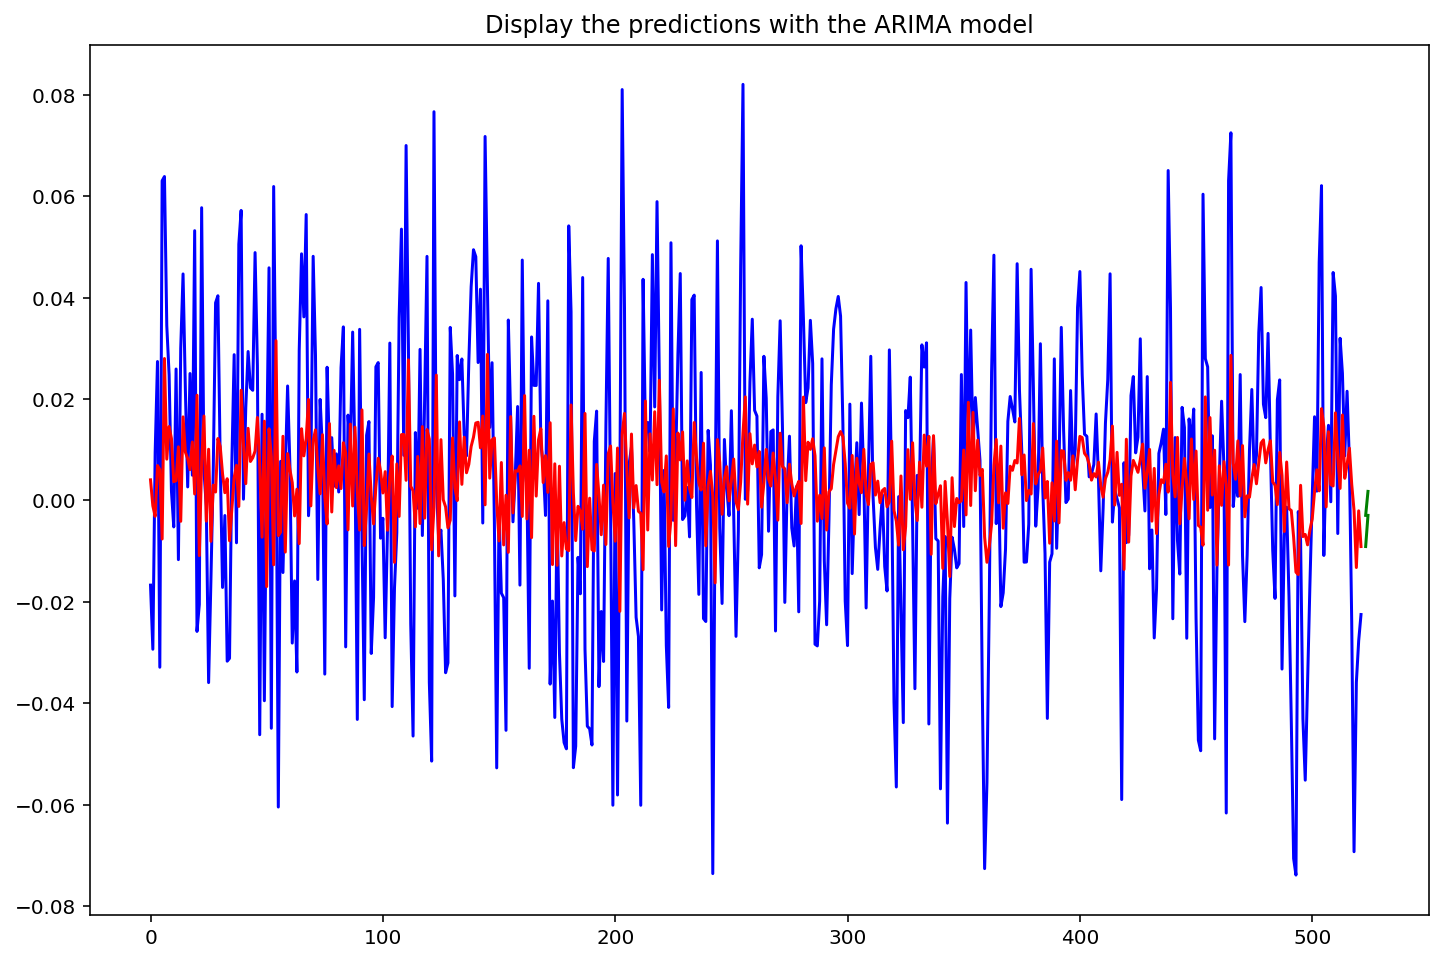

In [30]:
steps = 2

forecast = ar1.forecast(steps=steps)[0]

plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')

preds = ar1.fittedvalues
plt.plot(preds, color='red')

plt.plot(pd.DataFrame(np.array([preds[-1],forecast[0]]).T,index=range(len(udiff.values)+1, len(udiff.values)+3)), color='green')
plt.plot(pd.DataFrame(forecast,index=range(len(udiff.values)+1, len(udiff.values)+1+steps)), color='green')
plt.title('Display the predictions with the ARIMA model')
plt.show()